In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv
/kaggle/input/movie-rating-dataset/Files/data/movies.csv
/kaggle/input/movie-rating-dataset/Files/data/users.csv
/kaggle/input/movie-rating-dataset/Files/data/train.csv
/kaggle/input/movie-rating-dataset/Files/data/test.csv


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import sklearn.metrics as metrics
from sklearn.model_selection import ParameterGrid, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

import string
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from IPython.display import display

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Data exploration and EDA

Below consists of loading the data in a standard fashion. I then inspected the data and text to see what I am working with

In [3]:
news_test = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Test.csv")
news_train = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Train.csv")
news_solution = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv")
unique_categories = news_solution['Category'].unique()

In [4]:
display(pd.DataFrame(news_test).head())
display(pd.DataFrame(news_train).head())
display(pd.DataFrame(news_solution).head())

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


In [5]:
"""
Part 1 - EDA, Inspect, Visualize, Clean the data
Basic look at the text data and what we are trying to categorize
"""
#Sample full text on each category. Confirm same format
sample_texts = news_train.groupby('Category').sample(n=1)
# Print the 'Text' for each category
for category, row in sample_texts.iterrows():
    print(f"Category: {row['Category']}")
    print(f"Text: {row['Text']}")
    print("="*50)

Category: business
Text: imf agrees fresh turkey funding turkey has agreed a draft proposal with the international monetary fund to borrow $10bn (£5.19bn)  extending its ongoing financial support until 2007.  turkey s current $18.6bn loan agreement with the imf expires in february and the new deal would see it receive added support between 2005 and 2007. in return for the funding  turkey would be expected to keep inflation under control and introduce market reforms. turkey s economy has steadily recovered from a severe crisis in 2001.  economic growth has average 6-7% in the past three years  ahead of imf forecasts  while inflation fell below 10% this year for the first time in 30 years. however  turkey has a huge debt burden - already owing $23bn to the imf - while its current account deficit has swelled to $10.7bn this year.  the turkish economics minister  ali babacan  said the two sides had reached general agreement on a new three year funding program. rodrigo de rato  the imf s ma

NULL Values for Test and Train 0 0
count      735.000000
mean      2322.687075
std       1639.029711
min        727.000000
25%       1431.500000
50%       1979.000000
75%       2865.500000
max      25483.000000
Name: Text_length, dtype: float64
count     1490.000000
mean      2233.461745
std       1205.153358
min        501.000000
25%       1453.000000
50%       1961.000000
75%       2751.250000
max      18387.000000
Name: Text_length, dtype: float64


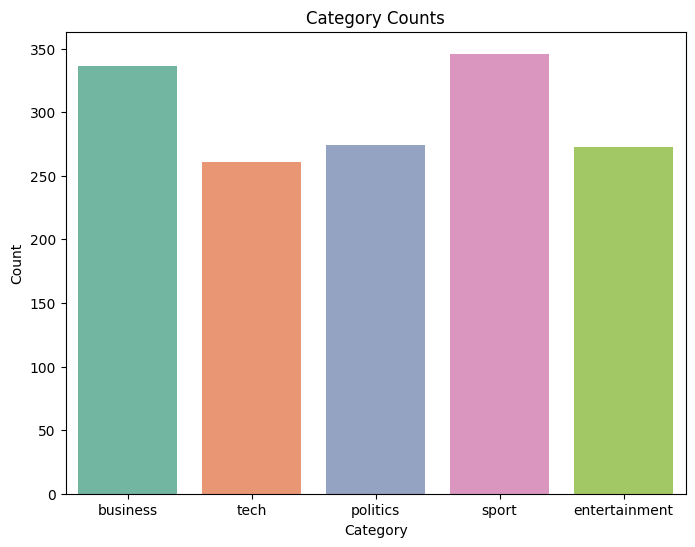

In [6]:
"""
Part 1 - EDA, Inspect, Visualize, Clean the data
"""
print('NULL Values for Test and Train', news_test['Text'].isnull().sum(), news_train['Text'].isnull().sum())
news_test['Text_length'] = news_test['Text'].apply(len)
print(news_test['Text_length'].describe())
news_train['Text_length'] = news_train['Text'].apply(len)
print(news_train['Text_length'].describe())

plt.figure(figsize=(8, 6))
sns.countplot(data=news_train, x='Category', palette='Set2')

plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

**The text cleaning process is pretty standard. Casing is used to prevent mismatch of the same word with different casing. Puncuation is not a factor so that was removed too. Tokenizing the text into individual words is necessary for later processing to weight and value them on an single word basis. Removing stop words do not add value to the analysis so words such as 'the', 'is', 'of' were removed. Lemmatize was a new concept for me and removes redundancy in words by converting words to their root form, for example 'running' would become 'run'. The final step is simply converting the text to its original form.**

In [7]:
"""
Part 1 - EDA, Inspect, Visualize, Clean the data
Format casing, remove puncuation, tokenize text, remove stop words, 
lemmatize, join back into single string
Apply changes at bottom to both test and train
"""
def text_cleaner(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    clean_text = ' '.join(tokens)
    clean_text = clean_text.strip()
    return clean_text


news_train['Clean_Text'] = news_train['Text'].apply(text_cleaner)
news_test['Clean_Text'] = news_test['Text'].apply(text_cleaner)

In [8]:
"""
Part 1 - EDA, Inspect, Visualize, Clean the data
Sample of change in texts
"""
print(news_train['Text'].iloc[0])
print("="*50)
print(news_train['Clean_Text'].iloc[0])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebbe

**I found wordcloud to be a helpful data visualization. It is simple to digest and get an understanding of high frequency, important words per category**

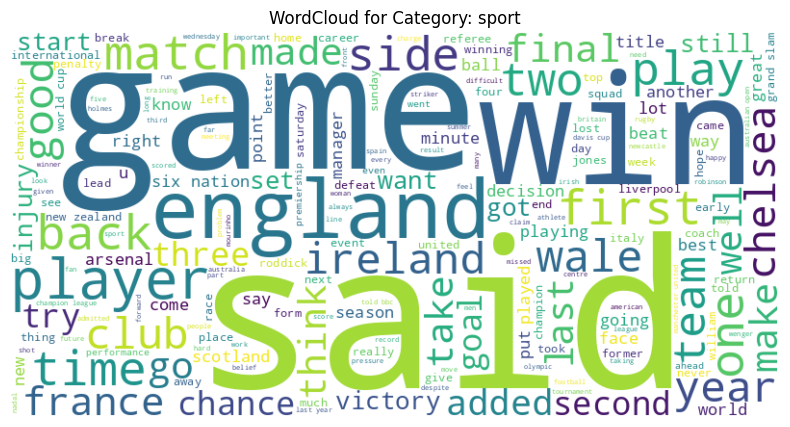

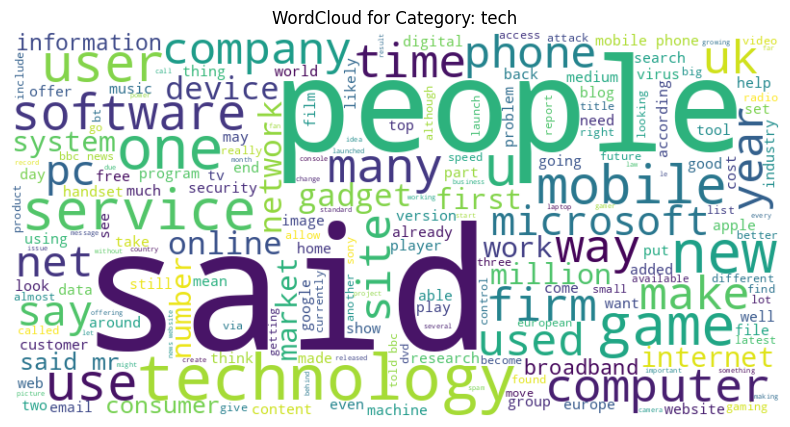

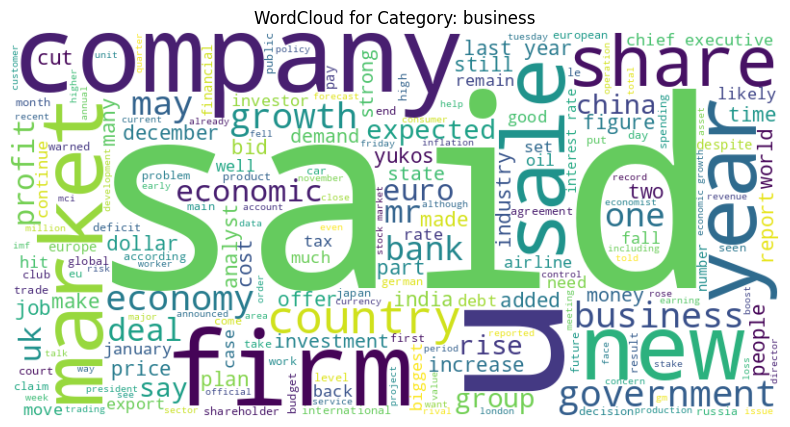

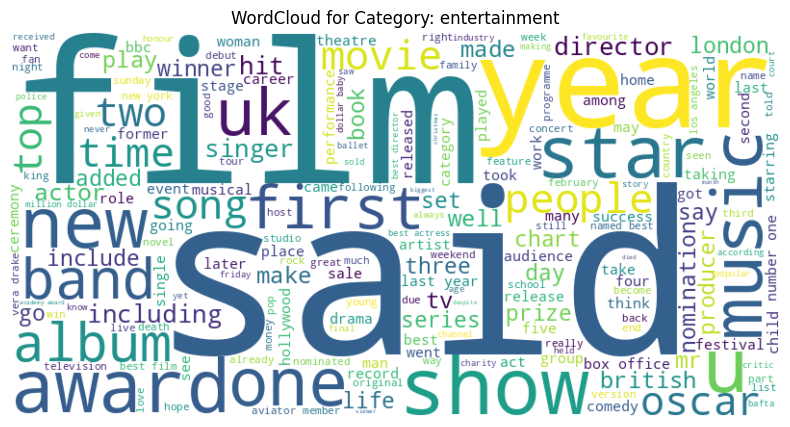

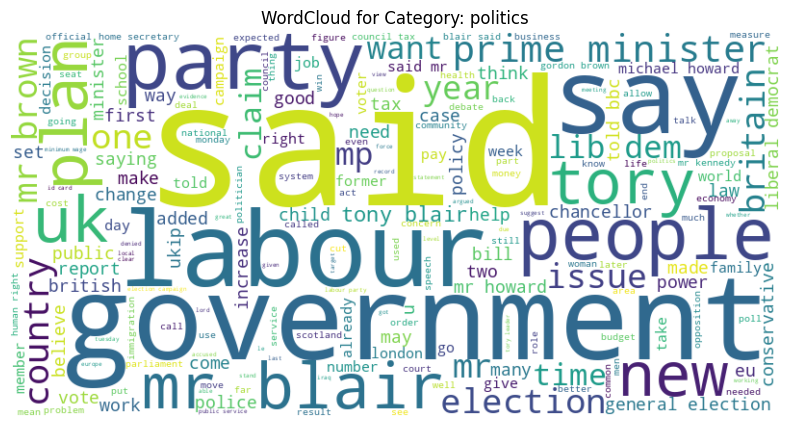

In [9]:
"""
Part 1 - EDA, Inspect, Visualize, Clean the data
Basic wordcloud displays to see commonly used words per topic
"""
for category in unique_categories:
    clean_text = ' '.join(news_train[news_train['Category'] == category]['Clean_Text'])
    wordcloud = WordCloud(
    width=800, height=400, background_color='white', colormap='viridis'
    ).generate(clean_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Category: {category}")
    plt.show()

Below I am using the TfidfVectorizer. This library is used for text processing and converts the representation to numerical. It pairs well with NMF in the numerical format. TfidfVectorizer creates a matrix with rows as documents and columns as terms. In our example documents are a text article and columns are the text. The weighting of each term is based on the formula below.

TF-IDF Formula:
TF-IDF = TF × IDF

Term Frequency (TF):
TF = (Number of times the word appears in a document) / (Total number of words in the document)

Inverse Document Frequency (IDF):
IDF = log(Total number of documents / (1 + Number of documents containing the word))

**References**

https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/

For the unsupervised building and training of models below I am following the same pattern for all (TfidVector, CountVectorizer).

1. Transform text to a numeric format with Tfid or CountVectorizer in matrix form.
2. Matrix is fed into the NMF model
3. NMF model decomposes the matrix and returns document to topic, and topic to word matrices
4. Use document to topic output to find index of dominant topic
5. Iterate over topics to find the best ordering (this is needed in unsupervised)
6. Use best ordering to test accuracy


In [10]:
"""
Part 2 - Building and training models
Steps 1,2,3 below. Accuracy attached in screenshot from submission
"""
# Train Phase: Fit TfidfVectorizer and NMF on training data
tfidv = TfidfVectorizer(min_df=0, max_df=0.80, norm='l2')
doc_term_train = tfidv.fit_transform(news_train['Clean_Text'])  # Fit TF-IDF on train data

nmf_model = NMF(n_components=5, init='nndsvd', solver='cd', beta_loss='frobenius', l1_ratio=0.5)
train_nmf = nmf_model.fit(doc_term_train)  # Fit NMF on the training data

W_train = nmf_model.transform(doc_term_train)  # Transform train data
H_train = nmf_model.components_  # Get the components (topics)

# Test Phase: Transform test data using the same TfidfVectorizer and NMF model
doc_term_test = tfidv.transform(news_test['Clean_Text'])  # Transform test data using the same TF-IDF model
W_test = nmf_model.transform(doc_term_test)  # Use the same NMF model to transform the test data
# No need to fit NMF again on the test data
H_test = nmf_model.components_

predicted_train_topics = np.argmax(W_train, axis=1)  # This gives the index of the most dominant topic for each document
predicted_test_topics = np.argmax(W_test, axis=1)  # Same for test data

from collections import Counter
# Map predicted topics to actual categories (you can inspect how categories are distributed across topics)
train_topic_labels = {}
for topic in range(nmf_model.n_components):
    # Get the documents in the current topic
    topic_docs = [i for i, t in enumerate(predicted_train_topics) if t == topic]
    topic_categories = news_train.iloc[topic_docs]['Category']
    most_common_category = Counter(topic_categories).most_common(1)[0][0]
    train_topic_labels[topic] = most_common_category

# Map predicted topics to categories in the test data using the same mapping
predicted_train_categories = [train_topic_labels[topic] for topic in predicted_train_topics]
predicted_test_categories = [train_topic_labels[topic] for topic in predicted_test_topics]

# Step 3: Evaluate how well the predicted categories match the actual categories in news_solution
# Compare the predicted categories with the actual categories (for both train and test)
train_accuracy = accuracy_score(news_train['Category'], predicted_train_categories)
test_accuracy = accuracy_score(news_solution['Category'], predicted_test_categories)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

my_submission = pd.DataFrame({
    'ArticleId': news_solution['ArticleId'],
    'Category': predicted_test_categories
})
my_submission.to_csv('tfidv_submission.csv', index=False)

Train Accuracy: 91.61%


**Wordcloud was helpful but can be a bit chaotic, below helps for the top 20 terms**

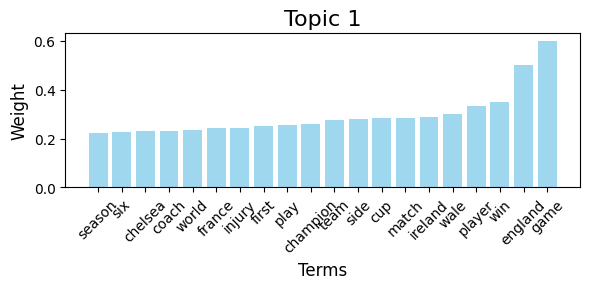

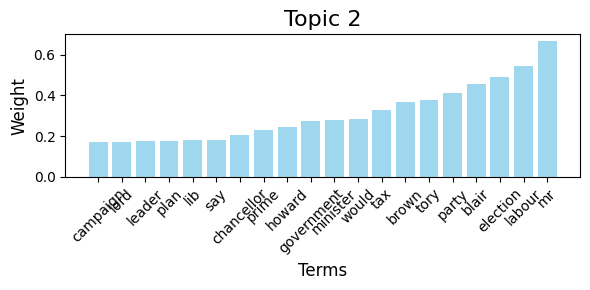

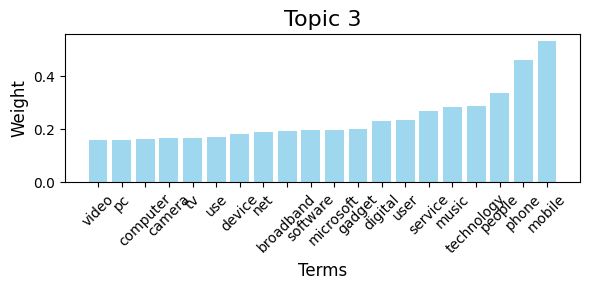

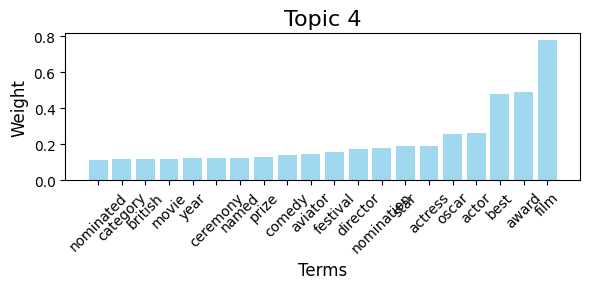

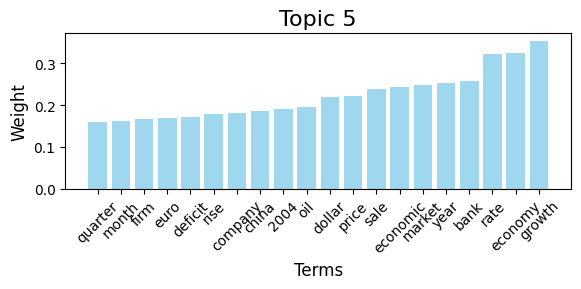

In [11]:
"""
Explain below
"""
from itertools import permutations

feature_names = tfidv.get_feature_names_out()

def plot_stacked_bar_chart_by_topic(H, feature_names, n_top_terms=20):
    for i, topic in enumerate(H):
        top_features_ind = topic.argsort()[-n_top_terms:]
        top_features_names = feature_names[top_features_ind]
        weights = topic[top_features_ind]
        plt.figure(figsize=(6, 3))
        plt.bar(top_features_names, weights, color='skyblue', alpha=0.8)
        plt.xticks(rotation=45, fontsize=10)
        plt.title(f"Topic {i+1}", fontsize=16)
        plt.ylabel("Weight", fontsize=12)
        plt.xlabel("Terms", fontsize=12)
        plt.tight_layout()
        plt.show()
plot_stacked_bar_chart_by_topic(H_train, feature_names)

**Same process above is followed with the addition of testing against different hyperparams**

In [12]:
"""
Part 2 - Building and training models
Steps 1,2,3,4 below. Accuracy attached in screenshot from submission
Step 4 - Hyperparams are in grids and tested for variations of TfidfVectorizer and NMF. Submitting combo with best train accuracy
"""

def run_nmf_with_tfidf(news_train, news_test, news_solution, tfidf_params, nmf_params):
    """
    Runs TF-IDF Vectorizer and NMF with specified parameters and evaluates performance.

    Args:
        news_train (pd.DataFrame): Training data with 'Clean_Text' and 'Category' columns.
        news_test (pd.DataFrame): Test data with 'Clean_Text' column.
        news_solution (pd.DataFrame): Solution data with 'Category' column.
        tfidf_params (dict): Parameters for TfidfVectorizer.
        nmf_params (dict): Parameters for NMF.

    Returns:
        dict: Dictionary containing train/test accuracy and parameters.
    """
    # Train Phase
    tfidv = TfidfVectorizer(**tfidf_params)
    doc_term_train = tfidv.fit_transform(news_train['Clean_Text'])  # Fit TF-IDF on train data

    nmf_model = NMF(**nmf_params)
    nmf_model.fit(doc_term_train)  # Fit NMF on the training data

    W_train = nmf_model.transform(doc_term_train)  # Transform train data

    # Test Phase
    doc_term_test = tfidv.transform(news_test['Clean_Text'])  # Transform test data using the same TF-IDF model
    W_test = nmf_model.transform(doc_term_test)  # Use the same NMF model to transform the test data

    predicted_train_topics = np.argmax(W_train, axis=1)  # Dominant topic for each document
    predicted_test_topics = np.argmax(W_test, axis=1)

    # Map topics to categories
    train_topic_labels = {}
    for topic in range(nmf_model.n_components):
        topic_docs = [i for i, t in enumerate(predicted_train_topics) if t == topic]
        topic_categories = news_train.iloc[topic_docs]['Category']
        most_common_category = Counter(topic_categories).most_common(1)[0][0]
        train_topic_labels[topic] = most_common_category

    predicted_train_categories = [train_topic_labels[topic] for topic in predicted_train_topics]
    predicted_test_categories = [train_topic_labels[topic] for topic in predicted_test_topics]

    # Evaluate
    train_accuracy = accuracy_score(news_train['Category'], predicted_train_categories)
    # test_accuracy = accuracy_score(news_solution['Category'], predicted_test_categories)

    return {
        'tfidf_params': tfidf_params,
        'nmf_params': nmf_params,
        'train_accuracy': train_accuracy,
        # 'test_accuracy': test_accuracy,
        'predicted_test_categories': predicted_test_categories
    }

# Example: Run with multiple hyperparameter sets
tfidf_param_grid = [
    {'min_df': 0.01, 'max_df': 0.8, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 1)},
    {'min_df': 0.05, 'max_df': 0.9, 'norm': 'l1', 'use_idf': False, 'ngram_range': (1, 2)},
    {'min_df': 0.001, 'max_df': 0.7, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 2)}
]

nmf_param_grid = [
    {'n_components': 5, 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.5},
    {'n_components': 10, 'init': 'nndsvdar', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.3},
    {'n_components': 15, 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.7}
]

results = []
for tfidf_params in tfidf_param_grid:
    for nmf_params in nmf_param_grid:
        result = run_nmf_with_tfidf(news_train, news_test, news_solution, tfidf_params, nmf_params)
        results.append(result)

# Print Results
for res in results:
    print(f"TF-IDF Params: {res['tfidf_params']}")
    print(f"NMF Params: {res['nmf_params']}")
    print(f"Train Accuracy: {res['train_accuracy'] * 100:.2f}%")
    print("-" * 40)


best_tfidv_result = max(results, key=lambda res: res['train_accuracy'])
best_categories = best_tfidv_result['predicted_test_categories']
my_submission = pd.DataFrame({
    'ArticleId': news_solution['ArticleId'],
    'Category': best_categories
})
my_submission.to_csv('tfidv_params_submission.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


TF-IDF Params: {'min_df': 0.01, 'max_df': 0.8, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 1)}
NMF Params: {'n_components': 5, 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.5}
Train Accuracy: 91.95%
----------------------------------------
TF-IDF Params: {'min_df': 0.01, 'max_df': 0.8, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 1)}
NMF Params: {'n_components': 10, 'init': 'nndsvdar', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.3}
Train Accuracy: 92.68%
----------------------------------------
TF-IDF Params: {'min_df': 0.01, 'max_df': 0.8, 'norm': 'l2', 'use_idf': True, 'ngram_range': (1, 1)}
NMF Params: {'n_components': 15, 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.7}
Train Accuracy: 91.01%
----------------------------------------
TF-IDF Params: {'min_df': 0.05, 'max_df': 0.9, 'norm': 'l1', 'use_idf': False, 'ngram_range': (1, 2)}
NMF Params: {'n_components': 5, 'init': 'nndsvda', 'solver': 'c

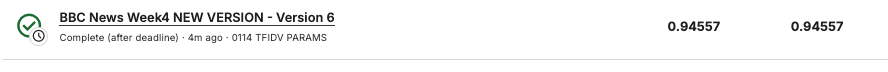

I elected to use CountVectorizer for the different feature extraction method. It is comparable to TF-IDF but simpler. The biggest difference is that it treats all words equally, where common words will have a stronger representation. The output of both TF-IDF and CountVectorizer is a matrix, CountVectorizer is more straightforward in nature.

**References**

https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c

In [13]:
"""
Part 2 - Building and training models
Steps 1,2,3,4, 5 below. Accuracy attached in screenshot from submission
Step 4 - Hyperparams are in grids and tested for variations of TfidfVectorizer and NMF. Submitting combo with best train accuracy
"""
def run_nmf_with_countvectorizer(news_train, news_test, news_solution, count_params, nmf_params):
    """
    Runs CountVectorizer and NMF with specified parameters and evaluates performance.

    """
    # Train Phase
    count_vectorizer = CountVectorizer(**count_params)
    doc_term_train = count_vectorizer.fit_transform(news_train['Clean_Text'])  # Fit CountVectorizer on train data

    nmf_model = NMF(**nmf_params)
    nmf_model.fit(doc_term_train)  # Fit NMF on the training data

    W_train = nmf_model.transform(doc_term_train)  # Transform train data

    # Test Phase
    doc_term_test = count_vectorizer.transform(news_test['Clean_Text'])  # Transform test data using the same CountVectorizer model
    W_test = nmf_model.transform(doc_term_test)  # Use the same NMF model to transform the test data

    predicted_train_topics = np.argmax(W_train, axis=1)  # Dominant topic for each document
    predicted_test_topics = np.argmax(W_test, axis=1)

    # Map topics to categories
    train_topic_labels = {}
    for topic in range(nmf_model.n_components):
        topic_docs = [i for i, t in enumerate(predicted_train_topics) if t == topic]
        topic_categories = news_train.iloc[topic_docs]['Category']
        most_common_category = Counter(topic_categories).most_common(1)[0][0]
        train_topic_labels[topic] = most_common_category

    predicted_train_categories = [train_topic_labels[topic] for topic in predicted_train_topics]
    predicted_test_categories = [train_topic_labels[topic] for topic in predicted_test_topics]

    # Evaluate
    train_accuracy = accuracy_score(news_train['Category'], predicted_train_categories)
    test_accuracy = accuracy_score(news_solution['Category'], predicted_test_categories)

    return {
        'count_params': count_params,
        'nmf_params': nmf_params,
        'train_accuracy': train_accuracy,
        # 'test_accuracy': test_accuracy
        'predicted_test_categories': predicted_test_categories
    }

# Example: Run with multiple hyperparameter sets
count_param_grid = [
    {'min_df': 0.01, 'max_df': 0.8, 'ngram_range': (1, 1)},
    {'min_df': 0.05, 'max_df': 0.9, 'ngram_range': (1, 2)},
    {'min_df': 0.001, 'max_df': 0.7, 'ngram_range': (1, 2)}
]

nmf_param_grid = [
    {'n_components': 5, 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.5},
    {'n_components': 10, 'init': 'nndsvdar', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.3},
    {'n_components': 15, 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.7}
]

results = []
for count_params in count_param_grid:
    for nmf_params in nmf_param_grid:
        result = run_nmf_with_countvectorizer(news_train, news_test, news_solution, count_params, nmf_params)
        results.append(result)

# Print Results
for res in results:
    print(f"CountVectorizer Params: {res['count_params']}")
    print(f"NMF Params: {res['nmf_params']}")
    print(f"Train Accuracy: {res['train_accuracy'] * 100:.2f}%")
    print("-" * 40)


best_count_vec_result = max(results, key=lambda res: res['train_accuracy'])
best_categories = best_count_vec_result['predicted_test_categories']
# print(best_count_vec_result)
my_submission = pd.DataFrame({
    'ArticleId': news_solution['ArticleId'],
    'Category': best_categories
})
my_submission.to_csv('count_vec_submission.csv', index=False)

CountVectorizer Params: {'min_df': 0.01, 'max_df': 0.8, 'ngram_range': (1, 1)}
NMF Params: {'n_components': 5, 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.5}
Train Accuracy: 82.42%
----------------------------------------
CountVectorizer Params: {'min_df': 0.01, 'max_df': 0.8, 'ngram_range': (1, 1)}
NMF Params: {'n_components': 10, 'init': 'nndsvdar', 'solver': 'mu', 'beta_loss': 'kullback-leibler', 'l1_ratio': 0.3}
Train Accuracy: 92.42%
----------------------------------------
CountVectorizer Params: {'min_df': 0.01, 'max_df': 0.8, 'ngram_range': (1, 1)}
NMF Params: {'n_components': 15, 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.7}
Train Accuracy: 79.13%
----------------------------------------
CountVectorizer Params: {'min_df': 0.05, 'max_df': 0.9, 'ngram_range': (1, 2)}
NMF Params: {'n_components': 5, 'init': 'nndsvda', 'solver': 'cd', 'beta_loss': 'frobenius', 'l1_ratio': 0.5}
Train Accuracy: 69.73%
-------------------

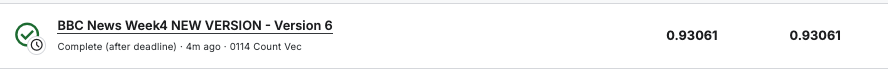

# Compare with supervised learning

In [14]:
"""
Compare with supervised learning sections below
"""

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Load and preprocess the dataset
train_data = news_train
# Apply TF-IDF vectorization
vectorizer = TfidfVectorizer(min_df=0, max_df=0.85, norm='l2', stop_words='english')
features = vectorizer.fit_transform(train_data['Clean_Text'])
labels = train_data['Category']

# Split the data into training and testing subsets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize the models
model_dict = {
    'Support Vector Classifier': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42)
}

# Different train sizes to evaluate
train_sizes = [0.1, 0.2, 0.5, 1.0]

# Dictionary to store results
evaluation_results = {
    'Model': [],
    'Train Size': [],
    'Train Accuracy': [],
    'Test Accuracy': []
}

for name, model in model_dict.items():
    print(f"Evaluating {name}")
    for size in train_sizes:
        subset_size = int(size * X_train.shape[0])
        
        # Fit the model
        model.fit(X_train[:subset_size], y_train[:subset_size])
        
        # Make predictions
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)
        
        # Calculate accuracies
        train_acc = accuracy_score(y_train, train_predictions)
        test_acc = accuracy_score(y_test, test_predictions)
        
        # Store the results
        evaluation_results['Model'].append(name)
        evaluation_results['Train Size'].append(f'{size * 100}%')
        evaluation_results['Train Accuracy'].append(f"{train_acc:.2%}")
        evaluation_results['Test Accuracy'].append(f"{test_acc:.2%}")

supervised_results_df = pd.DataFrame(evaluation_results)
supervised_results_df

Evaluating Support Vector Classifier
Evaluating Logistic Regression
Evaluating Random Forest Classifier


,Model,Train Size,Train Accuracy,Test Accuracy
0,Support Vector Classifier,10.0%,59.82%,54.03%
1,Support Vector Classifier,20.0%,88.34%,86.58%
2,Support Vector Classifier,50.0%,96.90%,93.96%
3,Support Vector Classifier,100.0%,100.00%,96.31%
4,Logistic Regression,10.0%,72.32%,69.13%
5,Logistic Regression,20.0%,92.03%,91.28%
6,Logistic Regression,50.0%,97.65%,95.30%
7,Logistic Regression,100.0%,99.75%,96.98%
8,Random Forest Classifier,10.0%,80.54%,77.85%
9,Random Forest Classifier,20.0%,91.95%,92.95%


In [15]:
"""
Using RandomForest at the supervised model for submissions against different training sizes
"""

# Load and preprocess the data
train_data = news_train
vectorizer = TfidfVectorizer(min_df=0, max_df=0.85, norm='l2', stop_words='english')
X = vectorizer.fit_transform(train_data['Clean_Text'])
y = train_data['Category']
# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
# Initialize SVM model
rf = RandomForestClassifier(random_state=42)
# List of train sizes to evaluate
train_sizes = [0.2, 0.5, 1.0]
# Loop over each train size
for size in train_sizes:
    # Define the train size for the current iteration
    train_size = int(size * X_train.shape[0])
    # Train the SVM model on the current subset of the data
    rf.fit(X_train[:train_size], y_train[:train_size])
    # Transform the test data using the same vectorizer
    X_test_transformed = vectorizer.transform(news_test['Text'])
    # Predict the categories on the test set
    y_test_pred = rf.predict(X_test_transformed)
    # Create a DataFrame with the predictions
    test_pred = pd.DataFrame(columns=['ArticleId', 'Category'])
    test_pred['ArticleId'] = news_test['ArticleId']
    test_pred['Category'] = y_test_pred
    # Save the predictions to a CSV file
    test_pred.to_csv(f'supervised_test_accuracy_{int(size * 100)}.csv', index=False)

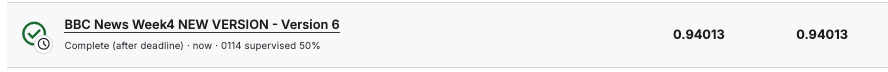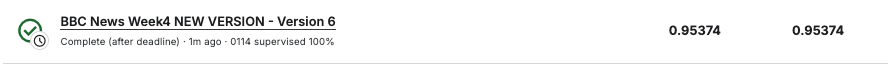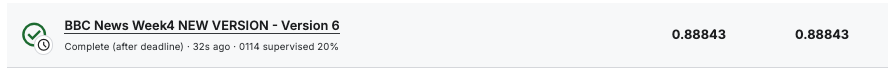

In [16]:
"""
Compare supervised vs unsupervised for 100% of training data
Test results for unsupervised attached from submission
"""

# supervised_results_df
filtered_supervised_df = supervised_results_df[supervised_results_df['Train Size'] == "100.0%"]
new_rows = pd.DataFrame({
    "Model": ["TF_IDF", "CountVector"],
    "Train Size": ["100.0%", "100.0%"],
    "Train Accuracy": [best_tfidv_result['train_accuracy'], best_count_vec_result['train_accuracy']],
    "Test Accuracy": ["94.56%", "93.01%"]
})

updated_df = pd.concat([filtered_supervised_df, new_rows], ignore_index=True)
print(updated_df)

                       Model Train Size Train Accuracy Test Accuracy
0  Support Vector Classifier     100.0%        100.00%        96.31%
1        Logistic Regression     100.0%         99.75%        96.98%
2   Random Forest Classifier     100.0%        100.00%        96.98%
3                     TF_IDF     100.0%       0.939597        94.56%
4                CountVector     100.0%       0.924161        93.01%


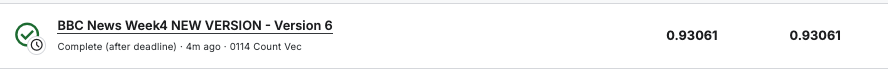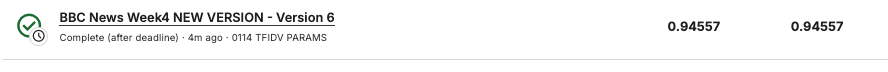

**Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?**


On 100% of the training data, the supervised learning models performed slightly better in terms of test accuracy. In terms of feature extraction the use of TF-IDF performed slightly better than CountVector. The train accuracy on the supervised models was 100% accuracy for nearly all of them, which would lead you to think its overfitting but the test accuracy was still impressive at around 96% for each model. I would expect a larger drop off in test accuracy with overfitting.

When looking at different train sizes (10%, 20%, 50%) for supervised models I was impressed by the test accuracy remaining high on smaller sizes. RandomForest performed reasonably well at just 10% of training data and SVM and LogisticalRegression all performed well at 20% of training size. The added flexibility of data efficiency with these models is a great benefit to have.



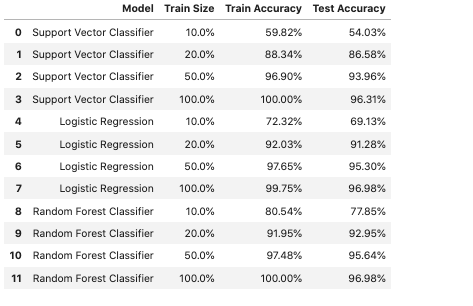